# tsam - 2. Example
Example usage of the time series aggregation module (tsam)
Date: 29.06.2019

Author: Maximilian Hoffmann

Import pandas and the relevant time series aggregation class

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
%matplotlib inline

### Input data 

Read in time series from testdata.csv with pandas

In [2]:
raw = pd.read_csv('testdata.csv', index_col = 0)

Show a slice of the dataset

In [3]:
raw.head()

,GHI,T,Wind,Load
2009-12-31 23:30:00,0,-2.1,7.1,375.478394
2010-01-01 00:30:00,0,-2.8,8.6,364.541326
2010-01-01 01:30:00,0,-3.3,9.7,357.416844
2010-01-01 02:30:00,0,-3.2,9.8,350.191306
2010-01-01 03:30:00,0,-3.2,9.4,345.161449


Show the shape of the raw input data: 4 types of timeseries (GHI, Temperature, Wind and Load) for every hour in a year

In [4]:
raw.shape

(8760, 4)

Create a plot function for the temperature for a visual comparison of the time series

In [5]:
def plotTS(data, periodlength, vmin, vmax):
    fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Hour')
    plt.xlabel('Day')

    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label('Wind [m/s]')

Plot an example series - in this case the wind speed

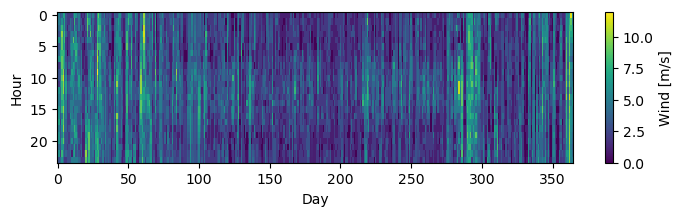

In [6]:
plotTS(raw['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

### Hierarchical aggregation

Initialize an aggregation class object with hierarchical clustering as method for eight typical days, without any integration of extreme periods. Alternative clusterMethod's are 'averaging','hierarchical' and 'k_medoids'.

In [7]:
aggregation = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'hierarchical', representationMethod='meanRepresentation')

Create the typical periods

In [8]:
typPeriods = aggregation.createTypicalPeriods()

In [9]:
typPeriods

GHI        Load         T      Wind
  TimeStep                                     
0 0         0.0  401.162755 -0.541667  2.837500
  1         0.0  390.314344 -0.875000  2.816667
  2         0.0  385.746997 -1.172917  2.668750
  3         0.0  385.847417 -1.360417  2.616667
  4         0.0  388.700611 -1.506250  2.556250
...         ...         ...       ...       ...
7 19        0.0  536.348654  3.112821  1.971795
  20        0.0  511.367680  2.992308  2.041026
  21        0.0  491.284883  2.851282  1.897436
  22        0.0  468.986028  2.717949  2.058974
  23        0.0  438.652594  2.638462  2.261538

[192 rows x 4 columns]

Show shape of typical periods: 4 types of timeseries for 8*24 hours

In [10]:
typPeriods.shape

(192, 4)

Repredict the original time series based on the typical periods

In [11]:
predictedPeriods = aggregation.predictOriginalData()

Plot the repredicted data

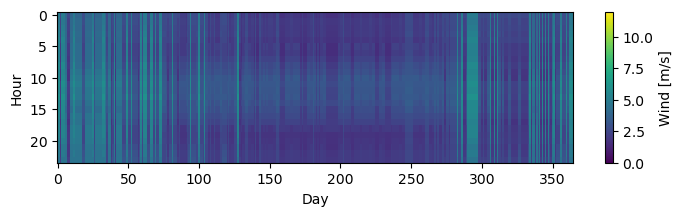

In [12]:
plotTS(predictedPeriods['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

### Now cluster the wind time series only

Clustering the solar time series only with 8 typical days and hierarchical clustering leads to different typical days in another sequence.

Isolate wind time series and show first lines of data

In [13]:
raw_wind=raw.loc[:,'Wind'].to_frame()
raw_wind.head()

,Wind
2009-12-31 23:30:00,7.1
2010-01-01 00:30:00,8.6
2010-01-01 01:30:00,9.7
2010-01-01 02:30:00,9.8
2010-01-01 03:30:00,9.4


Now same clustering procedure as above for the isolated wind time series

In [14]:
aggregation_wind = tsam.TimeSeriesAggregation(raw_wind, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'hierarchical', representationMethod='meanRepresentation')

In [15]:
typPeriods_wind = aggregation_wind.createTypicalPeriods()

Export for preprocess time series for testing

In [16]:
aggregation_wind.normalizedPeriodlyProfiles.to_csv(os.path.join('results','preprocessed_wind.csv'))

In [17]:
typPeriods_wind.shape

(192, 1)

In [18]:
predictedPeriods_wind = aggregation_wind.predictOriginalData()

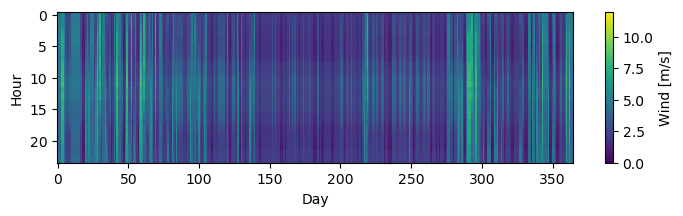

In [19]:
plotTS(predictedPeriods_wind['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

When we compare both plots, we see that 8 typical periods for wind only can better account extreme periods, but the cluster order in general changes

In [20]:
aggregation.clusterOrder

array([2, 2, 7, 2, 2, 2, 5, 7, 7, 5, 5, 2, 2, 5, 5, 5, 5, 5, 0, 0, 5, 5,
       5, 5, 5, 2, 0, 5, 5, 5, 5, 5, 2, 2, 5, 1, 5, 5, 7, 0, 2, 7, 5, 5,
       5, 5, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 7, 0, 2, 1, 2, 2, 2, 0, 0,
       2, 2, 0, 2, 0, 0, 2, 2, 1, 1, 1, 0, 7, 0, 0, 2, 0, 0, 0, 7, 1, 4,
       4, 4, 4, 3, 1, 0, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 1, 1, 3, 1, 4,
       4, 1, 3, 3, 3, 1, 1, 0, 0, 0, 4, 1, 3, 4, 4, 1, 1, 2, 2, 7, 6, 4,
       3, 1, 1, 3, 3, 4, 4, 6, 1, 6, 6, 1, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 1, 1, 3, 6, 6, 6, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 6, 4, 6, 6,
       6, 3, 3, 4, 4, 1, 3, 6, 3, 6, 4, 4, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 3, 4, 4, 1, 3, 3, 3, 3, 4, 6, 6, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 4, 4, 3, 3, 6, 6, 6, 4, 4, 3, 3, 6, 6, 6, 6, 4, 3, 3, 3, 3, 3,
       4, 4, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 4, 4, 3, 3, 1, 1, 1, 4,
       4, 3, 3, 1, 3, 1, 4, 4, 1, 1, 7, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 7, 7, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 7,

In [21]:
aggregation_wind.clusterOrder

array([7, 0, 0, 3, 3, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 5, 5, 4, 0,
       4, 0, 0, 0, 6, 4, 3, 0, 7, 2, 0, 0, 4, 6, 1, 2, 5, 1, 0, 2, 3, 0,
       0, 2, 2, 5, 6, 3, 6, 6, 7, 1, 6, 0, 1, 5, 4, 3, 4, 7, 0, 2, 2, 0,
       4, 0, 1, 7, 1, 1, 0, 0, 2, 1, 1, 2, 6, 1, 1, 4, 0, 2, 4, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 4, 0, 2, 0, 2, 2, 4, 2, 1, 2, 4, 0, 1, 1, 1, 5,
       1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 5, 1, 2, 2, 1, 0, 4, 5, 0, 1,
       1, 5, 1, 1, 4, 2, 2, 0, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 5, 5, 1, 5, 1, 1, 2, 1, 2, 1, 2, 1, 1, 5, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 5, 5, 5, 2, 5, 1, 5, 5, 1, 1, 1, 1, 1, 5, 5, 1, 1,
       1, 1, 2, 2, 1, 5, 1, 2, 1, 1, 2, 1, 1, 1, 5, 1, 1, 5, 2, 4, 0, 7,
       2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 5, 1, 1, 5, 5, 5, 2, 2, 2, 1, 1,
       2, 2, 1, 2, 2, 1, 1, 4, 2, 1, 5, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2,
       5, 1, 2, 1, 5, 1, 5, 1, 1, 1, 5, 1, 0, 0, 2, 2, 5, 2, 2, 0, 4, 2,
       4, 1, 5, 0, 3, 3, 3, 7, 4, 0, 3, 0, 0, 2, 1,

### Predefining cluster sequence

tsam offers the option to aggregate input time series for a predefined cluster order. This means that we can take the cluster Order from the wind time series only and set it as input for the aggregation process for all attributes

In [22]:
aggregation_predefClusterOrder = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                 clusterMethod = 'hierarchical', representationMethod='meanRepresentation', 
                                 predefClusterOrder=aggregation_wind.clusterOrder)

In [23]:
typPeriods_predefClusterOrder = aggregation_predefClusterOrder.createTypicalPeriods()

In [24]:
typPeriods_predefClusterOrder.shape

(192, 4)

Save typical periods to .csv file

In [25]:
typPeriods_predefClusterOrder.to_csv(os.path.join('results','testperiods_predefClusterOrder.csv'))

In [26]:
predictedPeriods_predefClusterOrder = aggregation_predefClusterOrder.predictOriginalData()

Now we compare the cluster orders

In [27]:
aggregation_wind.clusterOrder

array([7, 0, 0, 3, 3, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 5, 5, 4, 0,
       4, 0, 0, 0, 6, 4, 3, 0, 7, 2, 0, 0, 4, 6, 1, 2, 5, 1, 0, 2, 3, 0,
       0, 2, 2, 5, 6, 3, 6, 6, 7, 1, 6, 0, 1, 5, 4, 3, 4, 7, 0, 2, 2, 0,
       4, 0, 1, 7, 1, 1, 0, 0, 2, 1, 1, 2, 6, 1, 1, 4, 0, 2, 4, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 4, 0, 2, 0, 2, 2, 4, 2, 1, 2, 4, 0, 1, 1, 1, 5,
       1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 5, 1, 2, 2, 1, 0, 4, 5, 0, 1,
       1, 5, 1, 1, 4, 2, 2, 0, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 5, 5, 1, 5, 1, 1, 2, 1, 2, 1, 2, 1, 1, 5, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 5, 5, 5, 2, 5, 1, 5, 5, 1, 1, 1, 1, 1, 5, 5, 1, 1,
       1, 1, 2, 2, 1, 5, 1, 2, 1, 1, 2, 1, 1, 1, 5, 1, 1, 5, 2, 4, 0, 7,
       2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 5, 1, 1, 5, 5, 5, 2, 2, 2, 1, 1,
       2, 2, 1, 2, 2, 1, 1, 4, 2, 1, 5, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2,
       5, 1, 2, 1, 5, 1, 5, 1, 1, 1, 5, 1, 0, 0, 2, 2, 5, 2, 2, 0, 4, 2,
       4, 1, 5, 0, 3, 3, 3, 7, 4, 0, 3, 0, 0, 2, 1,

In [28]:
aggregation_predefClusterOrder.clusterOrder

array([7, 0, 0, 3, 3, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 5, 5, 4, 0,
       4, 0, 0, 0, 6, 4, 3, 0, 7, 2, 0, 0, 4, 6, 1, 2, 5, 1, 0, 2, 3, 0,
       0, 2, 2, 5, 6, 3, 6, 6, 7, 1, 6, 0, 1, 5, 4, 3, 4, 7, 0, 2, 2, 0,
       4, 0, 1, 7, 1, 1, 0, 0, 2, 1, 1, 2, 6, 1, 1, 4, 0, 2, 4, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 4, 0, 2, 0, 2, 2, 4, 2, 1, 2, 4, 0, 1, 1, 1, 5,
       1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 5, 1, 2, 2, 1, 0, 4, 5, 0, 1,
       1, 5, 1, 1, 4, 2, 2, 0, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 5, 5, 1, 5, 1, 1, 2, 1, 2, 1, 2, 1, 1, 5, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 5, 5, 5, 2, 5, 1, 5, 5, 1, 1, 1, 1, 1, 5, 5, 1, 1,
       1, 1, 2, 2, 1, 5, 1, 2, 1, 1, 2, 1, 1, 1, 5, 1, 1, 5, 2, 4, 0, 7,
       2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 5, 1, 1, 5, 5, 5, 2, 2, 2, 1, 1,
       2, 2, 1, 2, 2, 1, 1, 4, 2, 1, 5, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2,
       5, 1, 2, 1, 5, 1, 5, 1, 1, 1, 5, 1, 0, 0, 2, 2, 5, 2, 2, 0, 4, 2,
       4, 1, 5, 0, 3, 3, 3, 7, 4, 0, 3, 0, 0, 2, 1,

As it can be seen, the cluster order for the four attributes (i.e. he sequence of typical days) is no identical to the cluster order of the wind time series clustering. Now the color plots can be compared:

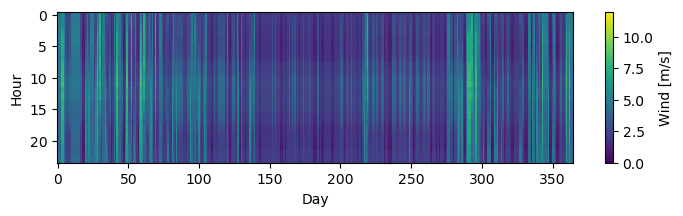

In [29]:
plotTS(predictedPeriods_predefClusterOrder['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

As it can be seen, the plot for the aggregated wind time series only and the one for four with the predefined cluster Order from the wind time series still differ from each other. This is because of the fact, that only the cluster Order, but not the cluster centers of each cluster are predefined. Since these are in one case deterined for the wind time series only and in the other case for all four attributes in common, the chosen cluster centers (chosen typical days) differ from each other

### Predefining cluster order and cluster centers

If the cluster order and the cluster centers should be taken from the wind time series clustering, we pass the information which days where chosen as typical days for the wind time series to the aggregation of all four typical attributes as well

In [30]:
aggregation_predefClusterOrderAndClusterCenters = tsam.TimeSeriesAggregation(raw, 
                                                  noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                                  clusterMethod = 'hierarchical', representationMethod='meanRepresentation', 
                                                  predefClusterOrder=aggregation_wind.clusterOrder,
                                                  predefClusterCenterIndices=aggregation_wind.clusterCenterIndices)

In [31]:
typPeriods_predefClusterOrderAndClusterCenters = aggregation_predefClusterOrderAndClusterCenters.createTypicalPeriods()

In [32]:
typPeriods_predefClusterOrderAndClusterCenters.shape

(192, 4)

Save typical periods to .csv file

In [33]:
typPeriods_predefClusterOrderAndClusterCenters.to_csv(os.path.join('results','testperiods_predefClusterOrderAndClusterCenters.csv'))

In [34]:
predictedPeriods_predefClusterOrderAndClusterCenters = aggregation_predefClusterOrderAndClusterCenters.predictOriginalData()

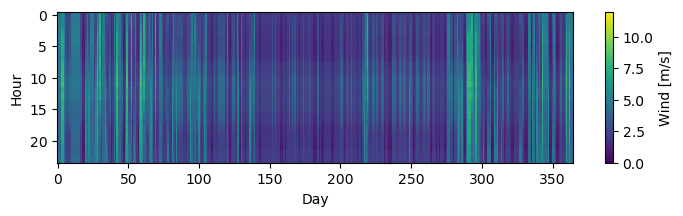

In [35]:
plotTS(predictedPeriods_predefClusterOrderAndClusterCenters['Wind'], 24, vmin = raw['Wind'].min(), vmax = raw['Wind'].max())

Now even the chosen typical days for the four attributes are the same as for the aggregated wind time series only